In [1]:
%load_ext autoreload
%autoreload 2
import Conv_model
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from tqdm import tqdm
import matplotlib.patches as mpatches
import imageio
import os
import matplotlib.image as mpimg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ERROR! Session/line number was not unique in database. History logging moved to new session 119


In [18]:
v1_weight_scale = 1
phase_weight_scale = 0.01
v4_weight_scale = 1

np.random.seed(0)
torch.manual_seed(0)

schoups_net = Conv_model.convnet(
    input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 4, 
    v4_orientation_number = 16, phis_sfs = 4, phis = True, sfs = False, training_size = 20, alpha = 0.01, 
    v1_rescale = v1_weight_scale, phase_rescale = phase_weight_scale, v4_rescale = v4_weight_scale)
# schoups_net.to(schoups_net.device)
schoups_net.transfer_inputting(-np.pi/60, np.pi/60, 11, 11, random_sf = False)
schoups_net.desired_outputting()
optimizer = optim.SGD(schoups_net.parameters(), lr = schoups_net.alpha)
schoups_net.train(10, optimizer)

# np.random.seed(0)
# torch.manual_seed(0)

# ghose_net = LCN_model.LCN(
#     input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 6, 
#     v4_orientation_number = 16, phis_sfs = 4, training_size = 20, phis = True, sfs = False, alpha = 0.01, rescale = 50)
# # ghose_net.to(ghose_net.device)
# ghose_net.transfer_inputting(-np.pi/18, np.pi/18, 11, 11, random_sf = False)
# ghose_net.desired_outputting()
# optimizer = optim.SGD(ghose_net.parameters(), lr = ghose_net.alpha)
# ghose_net.train(5000, optimizer)

NameError: name 'torch' is not defined

In [2]:
v1_weight_scale = 1
phase_weight_scale = 0.01
v4_weight_scale = 1
model = 'weight_scale_' + str(v1_weight_scale).replace('.', '') + '_001_' + str(v4_weight_scale).replace('.', '')


savepath = "./trained_models/conv_high_fixed_normalized/" + model + "/Schoups_32_orientations_model_"
# savepath = "./trained_models/automated_stds/15_07/Schoups_32_orientations_model_"

np.random.seed(0)
torch.manual_seed(0)

schoups_net = Conv_model.convnet(
    input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 6, 
    v4_orientation_number = 16, phis_sfs = 4, training_size = 20, phis = True, sfs = False, alpha = 0.01, 
    v1_rescale = v1_weight_scale, phase_rescale = phase_weight_scale, v4_rescale = v4_weight_scale, 
    v1_gamma = 0.5, v4_orientation_std = 0.7)
schoups_net.load_state_dict(torch.load(savepath[:-1] + ".pt"))
schoups_net.losses = torch.load(savepath + "loss.pt")
schoups_net.training_scores = torch.load(savepath + "performance.pt")
schoups_net.v1_weight_changes = torch.load(savepath + "v1_weight_change.pt")
schoups_net.v4_weight_changes = torch.load(savepath + "v4_weight_change.pt")
schoups_net.decision_weight_changes = torch.load(savepath + "decision_weight_change.pt")
schoups_net.angle1 = torch.load(savepath + "angle1.pt")
schoups_net.angle2 = torch.load(savepath + "angle2.pt")
schoups_net.train_x_location = torch.load(savepath + "x_location.pt")
schoups_net.train_y_location = torch.load(savepath + "y_location.pt")
schoups_net.generalize_perform = torch.load(savepath + "generalization_performance.pt")
schoups_net.generalize_error = torch.load(savepath + "generalization_error.pt")
schoups_net.trained_phis = torch.load(savepath + "phases.pt")
schoups_net.trained_sfs = torch.load(savepath + "sfs.pt")
schoups_net.v1_angles = torch.load(savepath + "v1_angles.pt")
schoups_net.v1_tuning_curve()
schoups_net.v4_tuning_curve()

savepath = "./trained_models/conv_low_randomized_normalized/" + model + "/Ghose_32_orientations_model_"

np.random.seed(0)
torch.manual_seed(0)

ghose_net = Conv_model.convnet(
    input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 6, 
    v4_orientation_number = 16, phis_sfs = 4, training_size = 20, phis = True, sfs = False, alpha = 0.01,
    v1_rescale = v1_weight_scale, phase_rescale = phase_weight_scale, v4_rescale = v4_weight_scale, 
    v1_gamma = 0.5, v4_orientation_std = 0.7)
ghose_net.load_state_dict(torch.load(savepath[:-1] + ".pt"))
ghose_net.losses = torch.load(savepath + "loss.pt")
ghose_net.training_scores = torch.load(savepath + "performance.pt")
ghose_net.v1_weight_changes = torch.load(savepath + "v1_weight_change.pt")
ghose_net.v4_weight_changes = torch.load(savepath + "v4_weight_change.pt")
ghose_net.decision_weight_changes = torch.load(savepath + "decision_weight_change.pt")
ghose_net.angle1 = torch.load(savepath + "angle1.pt")
ghose_net.angle2 = torch.load(savepath + "angle2.pt")
ghose_net.train_x_location = torch.load(savepath + "x_location.pt")
ghose_net.train_y_location = torch.load(savepath + "y_location.pt")
ghose_net.generalize_perform = torch.load(savepath + "generalization_performance.pt")
ghose_net.generalize_error = torch.load(savepath + "generalization_error.pt")
ghose_net.trained_phis = torch.load(savepath + "phases.pt")
ghose_net.trained_sfs = torch.load(savepath + "sfs.pt")
ghose_net.v1_angles = torch.load(savepath + "v1_angles.pt")
ghose_net.v1_tuning_curve()
ghose_net.v4_tuning_curve()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 170.90it/s]


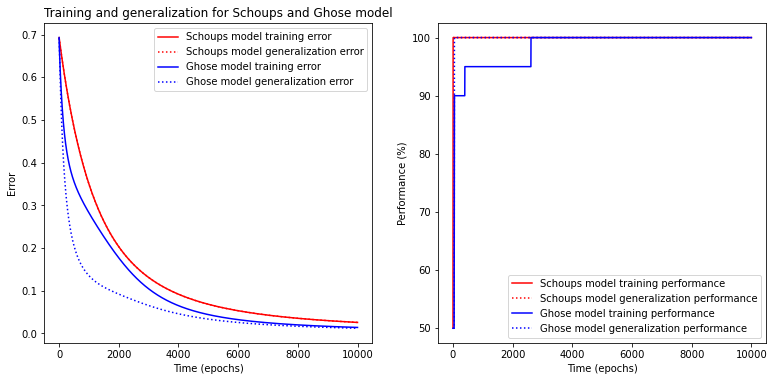

In [3]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
schoups_net.plot_training_error('red')
schoups_net.plot_generalization_error('red')
ghose_net.plot_training_error('blue')
ghose_net.plot_generalization_error('blue')
plt.legend(["Schoups model training error", "Schoups model generalization error", "Ghose model training error", 
            "Ghose model generalization error"]);
plt.title("Training and generalization for Schoups and Ghose model", loc = "left")

plt.subplot(3, 3, 2)
schoups_net.plot_training_performance('red')
schoups_net.plot_generalization_performance('red')
ghose_net.plot_training_performance('blue')
ghose_net.plot_generalization_performance('blue')
plt.legend(["Schoups model training performance", "Schoups model generalization performance", 
            "Ghose model training performance", "Ghose model generalization performance"]);



In [241]:
net3 = convnet(33, 6, 11, 2, alpha = 0.0001)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(50, optimizer, np.pi/4, np.pi/100, np.pi/16, 100)

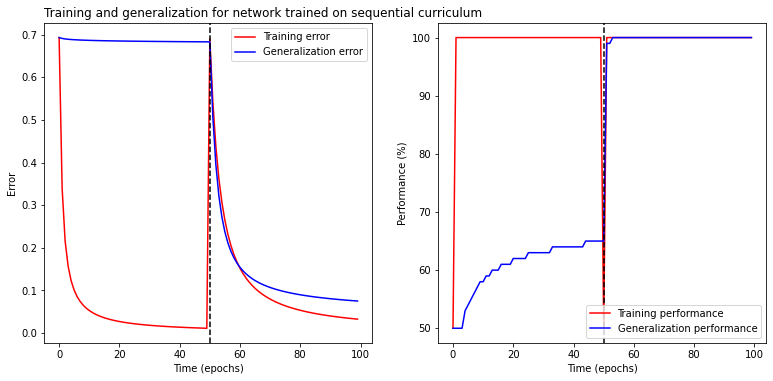

In [235]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');


100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 19.60it/s]


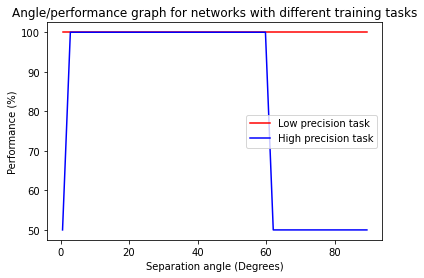

In [11]:
schoups_net.plot_angle_performance(40, 'red')
ghose_net.plot_angle_performance(40, 'blue')
# net3.plot_angle_performance(40, 'green')
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Angle/performance graph for networks with different training tasks", loc = 'center');

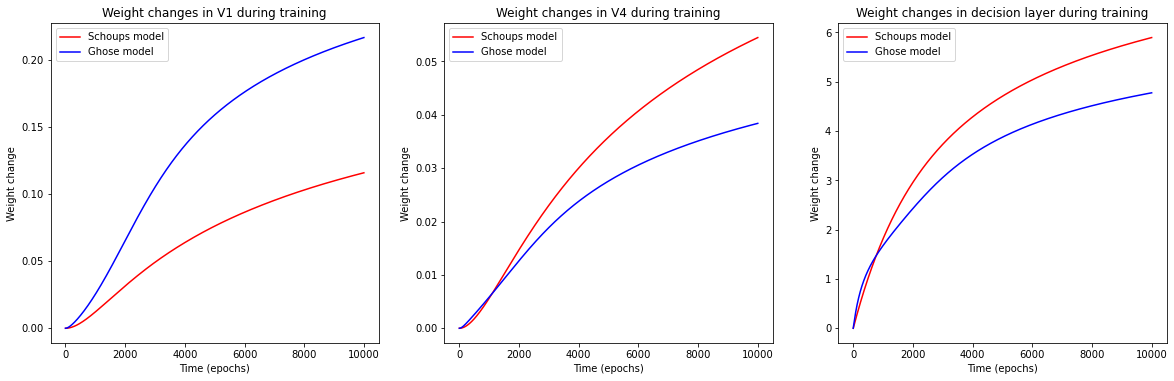

In [8]:
plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)

schoups_net.plot_weight_change('red', v1 = True)
ghose_net.plot_weight_change('blue', v1 = True)
plt.legend(["Schoups model", "Ghose model"]);

plt.subplot(3, 3, 2)
schoups_net.plot_weight_change('red', v4 = True)
ghose_net.plot_weight_change('blue', v4 = True)
plt.legend(["Schoups model", "Ghose model"]);

plt.subplot(3, 3, 3)
schoups_net.plot_weight_change('red', decision = True)
ghose_net.plot_weight_change('blue', decision = True)
plt.legend(["Schoups model", "Ghose model"]);

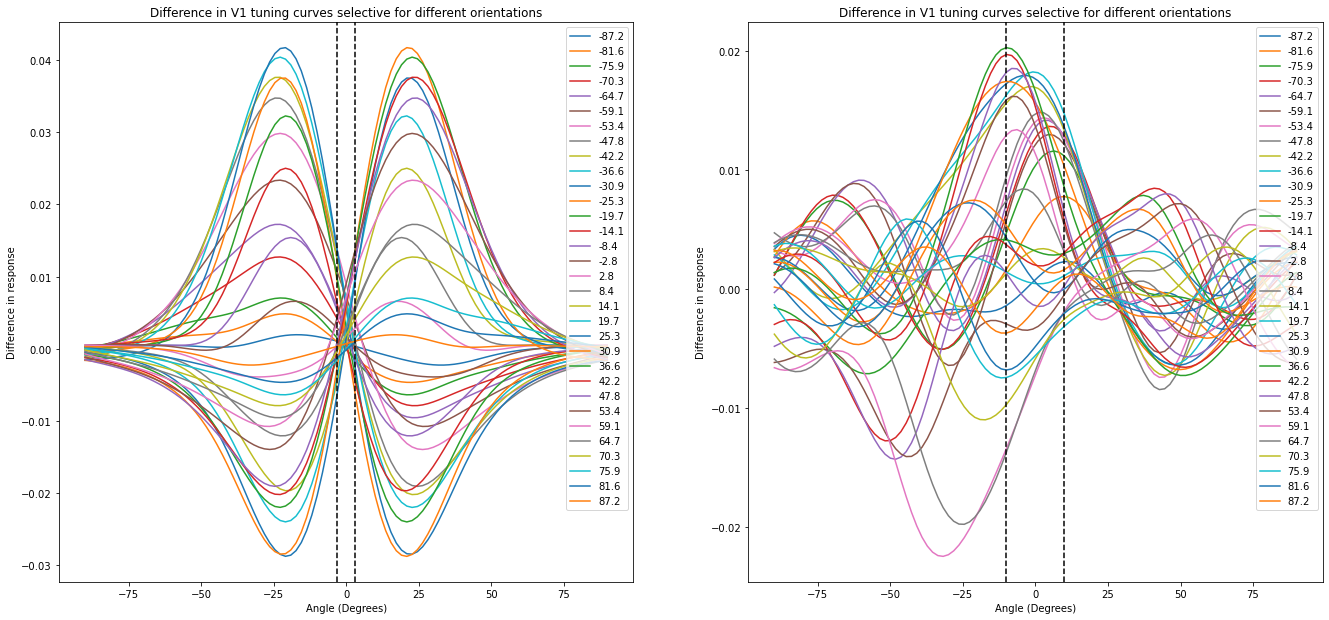

In [32]:
plt.figure(figsize = [35, 35])
difference = True
plt.subplot(3, 3, 1)
schoups_net.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, orientations = True, differences = difference);
plt.axvline(schoups_net.angle1 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
plt.axvline(schoups_net.angle2 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
# plt.title("V1 tuning curves after training")

plt.subplot(3, 3, 2)
ghose_net.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, orientations = True, differences = difference)
plt.axvline(ghose_net.angle1 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
plt.axvline(ghose_net.angle2 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');

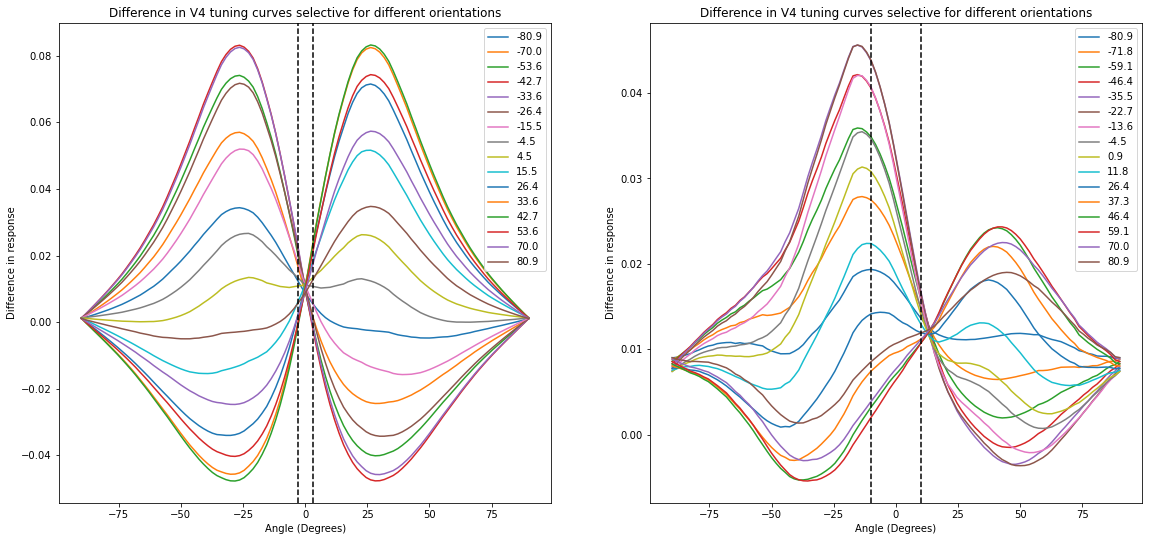

In [34]:
plt.figure(figsize = [30, 30])
difference = True

plt.subplot(3, 3, 1)
schoups_net.plot_v4_tuning_curve(differences = difference)
plt.axvline(schoups_net.angle1 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
plt.axvline(schoups_net.angle2 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
# plt.title("V4 tuning curves after training")

plt.subplot(3, 3, 2)
ghose_net.plot_v4_tuning_curve(differences = difference)
plt.axvline(ghose_net.angle1 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');
plt.axvline(ghose_net.angle2 * 180/np.pi, 0, 1, linestyle = 'dashed', color = 'black');


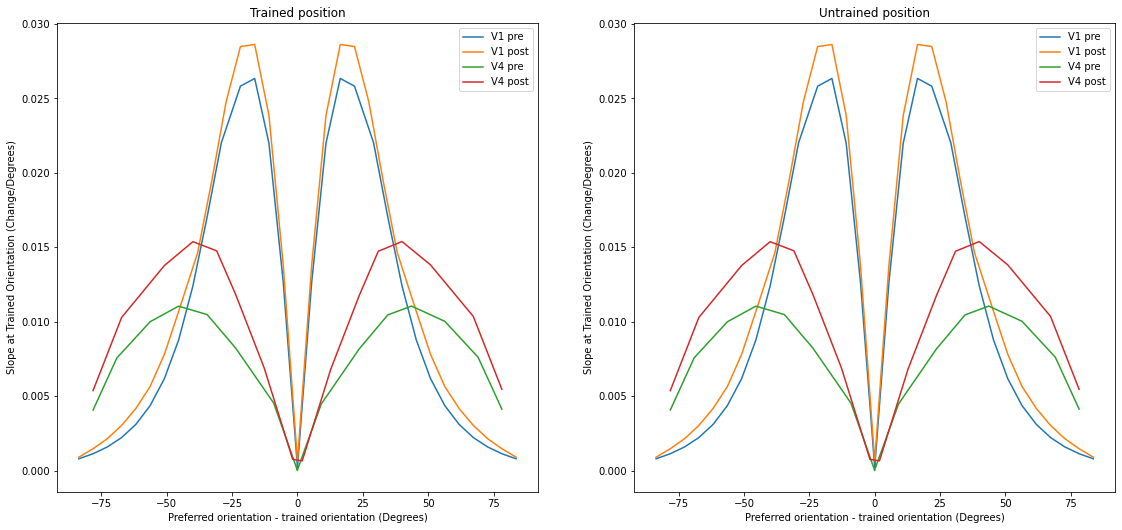

In [4]:
plt.figure(figsize = [50, 50])
plt.subplot(5, 5, 1)

schoups_net.otc_curve(v1_position_1 = 11, v1_position_2 = 11, v4_position_1 = 1, v4_position_2 = 1)
schoups_net.plot_otc_curve()
# plt.title("Schoups model");
plt.title("Trained position");

plt.subplot(5, 5, 2)

# ghose_net.otc_curve(v1_position_1 = 11, v1_position_2 = 11, v4_position_1 = 1, v4_position_2 = 1)
# ghose_net.plot_otc_curve()
# plt.title("Ghose model");

schoups_net.otc_curve(v1_position_1 = 3, v1_position_2 = 3, v4_position_1 = 0, v4_position_2 = 0)
schoups_net.plot_otc_curve()
plt.title("Untrained position");



### 

100%|███████████████████████████████████████████| 23/23 [00:31<00:00,  1.38s/it]


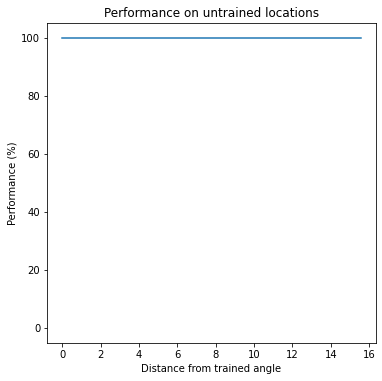

In [4]:
plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
np.random.seed(0)
torch.manual_seed(0)
schoups_net.plot_transfer_score(performance = True, grid = False)


100%|███████████████████████████████████████████| 23/23 [00:27<00:00,  1.20s/it]


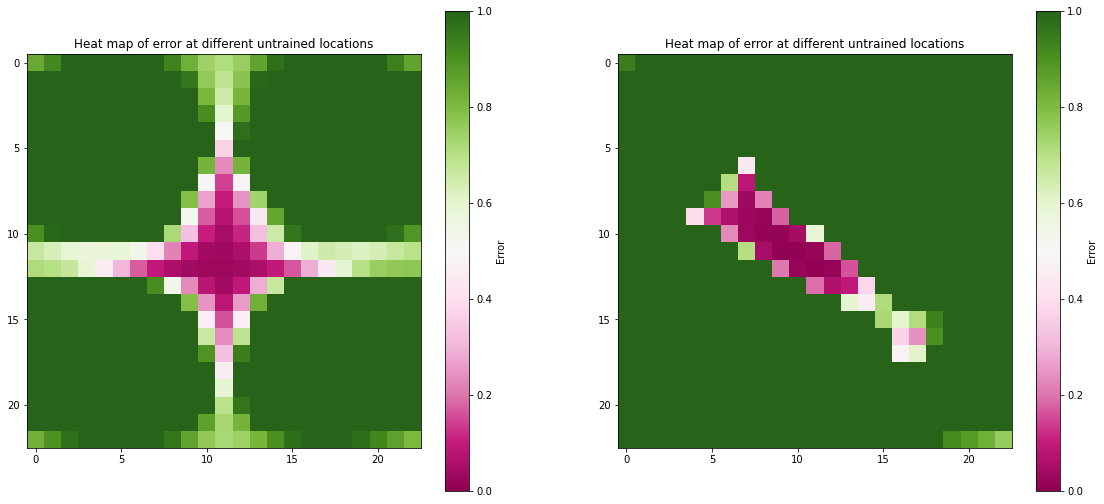

In [24]:
plt.figure(figsize = [30, 30])

plt.subplot(3, 3, 1)
np.random.seed(0)
torch.manual_seed(0)
schoups_net.plot_transfer_score(performance = False, grid = True)

plt.subplot(3, 3, 2)
np.random.seed(0)
torch.manual_seed(0)
ghose_net.plot_transfer_score(performance = False, grid = True)


In [31]:
schoups_net.simple_weight.weight[4][0]

tensor([[ 6.5651e-03,  2.1909e-03,  5.6453e-03,  1.1055e-02,  1.2535e-02,
          8.6044e-03,  3.7509e-03,  1.9485e-03,  2.1191e-03,  1.6305e-03,
         -9.8206e-05],
        [-1.5326e-02, -2.0878e-02, -1.5721e-02, -3.2591e-03,  8.0577e-03,
          1.2551e-02,  1.2987e-02,  1.2630e-02,  1.1279e-02,  8.9962e-03,
          6.0996e-03],
        [-8.4471e-02, -1.2876e-01, -1.6394e-01, -1.7883e-01, -1.7168e-01,
         -1.4686e-01, -1.0896e-01, -6.7665e-02, -3.3652e-02, -1.0996e-02,
          6.1141e-04],
        [ 2.1605e-03, -5.0806e-02, -1.3325e-01, -2.2961e-01, -3.1629e-01,
         -3.6696e-01, -3.6227e-01, -3.0745e-01, -2.2605e-01, -1.4315e-01,
         -7.7301e-02],
        [ 2.6434e-01,  3.7276e-01,  4.5292e-01,  4.6979e-01,  4.0276e-01,
          2.6574e-01,  1.0625e-01, -2.6739e-02, -1.0337e-01, -1.2078e-01,
         -9.9894e-02],
        [ 1.6496e-01,  3.2247e-01,  5.3292e-01,  7.5818e-01,  9.3360e-01,
          9.9945e-01,  9.3333e-01,  7.5753e-01,  5.3201e-01,  3.2241e-0

In [ ]:
net = convnet(11, 3, 5, 3)
x = np.linspace(0, np.pi, 3)
inputs = []
b = net.input(0, np.pi/2)

def init_weights(n):
    for i in range(n):
        theta = x[i]
        kernel = net.generate_gabor(5, theta)
        inputs.append(kernel)
    input = torch.stack(inputs).view(1, n, 5, 5)
    return input

conv1 = torch.nn.Conv2d(1, 3, 11, 11)
a = init_weights(3)
conv1.weight.data = a
maps = []
for i in range(net.training_size):
    input = b[0][i].view(1, 1, 11, 11)
    weight = conv1.weight.data[0][i].view(1, 1, 5, 5)
    result = F.conv2d(input, weight)
    maps.append(result)
    
maps

In [ ]:
sigma = nn.Parameter(torch.randn(1), requires_grad = True)


In [ ]:
net = convnet(11, 30, 5, 20)
a = net.input(0, np.pi/2)
def init_weights(n):
    inputs = []
    for i in range(n):
            theta = x[i]
            kernel = net.generate_gabor(11, theta)
            inputs.append(kernel)
#     b = torch.stack(inputs).view(1, n, 11, 11)
    return inputs
conv1 = torch.nn.Conv2d(1, 3, 5, 5)
a = init_weights(3)
# for i in range(len(inputs)):
#     result = conv1(a[i])
#     print(result)
a

In [ ]:
net = convnet(33, 30, 11, 20, alpha = 0.001)
x = net.input(-np.pi/2,np.pi/2).view(-1, 1, 11, 11)
y = net.desired_output()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net(x)

In [ ]:
b = torch.randn(3, 5, 5).view(3, 1, 5, 5)
a = nn.Conv2d(1, 3, 2)
a.weight.shape

In [ ]:
x = np.linspace(-np.pi/2, np.pi/2, 10)
ignore = 0
ambiguous = True
while ambiguous == True:
    if -np.pi/2 in x:
        ignore += 1
        np.delete(x, theta)
    if 0 in x:
        ignore += 1
        np.delete(x, theta)
    if np.pi/2 in x:
        ignore += 1
        np.delete(x, theta)
    x = np.linspace(x[0], x[-1], self.training_size)
    if -np.pi/2 in x or 0 in x or np.pi/2 in x:
        ambiguous = True
    else:
        ambiguous = False

In [362]:
ksize = 11
sigma = 3
lamda = 5
gamma = 0.5
theta = np.pi/3
phi = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
torch.linalg.norm(torch.tensor(kernel).view(11, 11), ord = 'fro')

tensor(4.8255, dtype=torch.float64)

In [235]:
x = np.linspace(0, np.pi/2, 5)
y = x[np.ix_(*[range(1, i, 2) for i in x.shape])]
x, y

(array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633]),
 array([0.39269908, 1.17809725]))

In [12]:
schoups_net.conv2.weight[0][4][4]

tensor([[9.4049e-05, 5.5574e-04, 2.2128e-03, 5.9372e-03, 1.0734e-02, 1.3076e-02,
         1.0734e-02, 5.9371e-03, 2.2128e-03, 5.5573e-04, 9.4042e-05],
        [5.5573e-04, 3.2840e-03, 1.3076e-02, 3.5084e-02, 6.3430e-02, 7.7272e-02,
         6.3430e-02, 3.5084e-02, 1.3076e-02, 3.2840e-03, 5.5573e-04],
        [2.2128e-03, 1.3076e-02, 5.2068e-02, 1.3970e-01, 2.5257e-01, 3.0768e-01,
         2.5257e-01, 1.3970e-01, 5.2068e-02, 1.3076e-02, 2.2128e-03],
        [5.9372e-03, 3.5084e-02, 1.3970e-01, 3.7483e-01, 6.7766e-01, 8.2553e-01,
         6.7766e-01, 3.7483e-01, 1.3970e-01, 3.5084e-02, 5.9371e-03],
        [1.0734e-02, 6.3430e-02, 2.5257e-01, 6.7766e-01, 1.2251e+00, 1.4925e+00,
         1.2251e+00, 6.7766e-01, 2.5257e-01, 6.3430e-02, 1.0734e-02],
        [1.3076e-02, 7.7272e-02, 3.0768e-01, 8.2553e-01, 1.4925e+00, 1.8182e+00,
         1.4925e+00, 8.2553e-01, 3.0768e-01, 7.7272e-02, 1.3076e-02],
        [1.0734e-02, 6.3430e-02, 2.5257e-01, 6.7766e-01, 1.2251e+00, 1.4925e+00,
         1.22

In [22]:
input = torch.tensor([[0.7, 0.3], [0.4, 0.5]])
output = nn.Softmax(dim = 1)
a = output(input)

input, a

(tensor([[0.7000, 0.3000],
         [0.4000, 0.5000]]),
 tensor([[0.5987, 0.4013],
         [0.4750, 0.5250]]))

In [35]:
input = torch.tensor([6]).float()
output = nn.Softmax()
a = torch.sigmoid(input)

input, a

(tensor([6.]), tensor([0.9975]))

In [145]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([5, -4]).view(1, 2).float()
target = torch.tensor([0]).view(1)
output = loss(input, target)
input, target, output
torch.argmax(input)

tensor(0)

In [78]:
schoups_net.forward(schoups_net.generate_location_gabor(np.pi/60, 0, 5, 5, 5, False))

torch.Size([1, 128, 23, 23])


tensor([[-7.2768,  7.3398]], grad_fn=<AddmmBackward>)

In [77]:
schoups_net.forward(schoups_net.generate_location_gabor(np.pi/60, 0, 5, 11, 11, False))

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  8.8091e-06,  3.8438e-05,  ...,  8.1177e-06,
            2.0241e-05,  0.0000e+00],
          [ 0.0000e+00,  2.1145e-05,  8.2803e-05,  ...,  4.9049e-05,
            6.4878e-05,  0.0000e+00],
          ...,
          [ 0.0000e+00,  6.2844e-05,  4.0840e-05,  ...,  5.5630e-05,
            1.3320e-05,  0.0000e+00],
          [ 0.0000e+00,  1.8568e-05,  5.1812e-06,  ...,  2.8551e-05,
            6.1416e-06,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  1.2636e-06,  9.8778e-06,  ...,  3.5448e-06,
           -1.6580e-05,  0.0000e+00],
          [ 0.0000e+00,  2.5819e-05,  1.4128e-04,  ...,  4.1868e-05,
           -6.7167e-06,  0.0000e+00],
          ...,
     

tensor([[ 2.1828, -2.1199]], grad_fn=<AddmmBackward>)

In [15]:
test = Conv_model.convnet(
    input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 1, 
    v4_orientation_number = 16, phis_sfs = 4, training_size = 20, phis = True, sfs = False, alpha = 0.01, 
    v1_rescale = v1_weight_scale, phase_rescale = phase_weight_scale, v4_rescale = v4_weight_scale, 
    v1_gamma = 0.5, v4_orientation_std = 0.7)

test.tuning_curve_sample = 100
test.v4_tuning_curve()

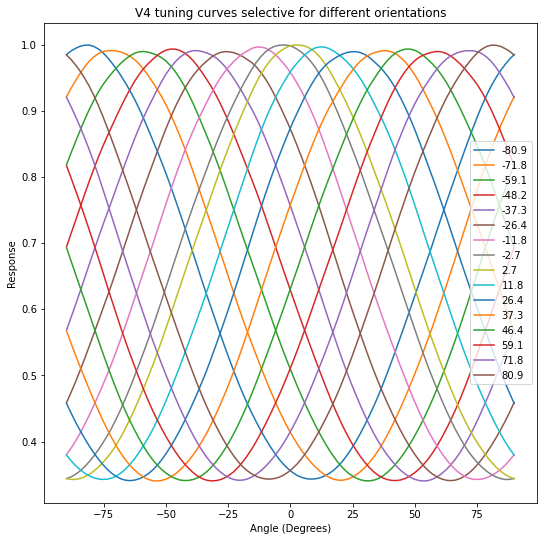

In [16]:
plt.figure(figsize = [30, 30])
plt.subplot(3, 3, 1)
test.plot_v4_tuning_curve(differences = False)


In [5]:
schoups_net.v4_dimensions

6

In [7]:
int(((33 - 11 + (2 * 5))/6) + 1)

6

In [59]:
print(torch.argmax(schoups_net.forward(schoups_net.generate_location_gabor(-np.pi/60, 0, 2.8, 11, 11, random_sf = False))))

tensor(1)


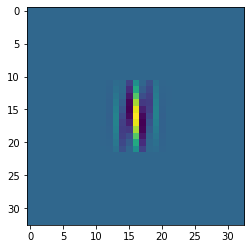

In [58]:
plt.imshow(schoups_net.generate_location_gabor(np.pi/60, 0, 2.9, 11, 11, random_sf = False).view(33, 33))

In [14]:
v1_weight_scale = 1
phase_weight_scale = 0.01
v4_weight_scale = 1
np.random.seed(0)
torch.manual_seed(0)

network = ghose_net

test = Conv_model.convnet(
    input_size = 33, v1_size = 11, v1_orientation_number = 32, v4_size = 11, v4_stride = 6, 
    v4_orientation_number = 16, phis_sfs = 4, training_size = 20, phis = True, sfs = False, alpha = 0.01, 
    v1_rescale = v1_weight_scale, phase_rescale = phase_weight_scale, v4_rescale = v4_weight_scale, 
    v1_gamma = 0.5, v4_orientation_std = 0.7)

test.trained_phis = network.trained_phis
test.trained_sfs = network.trained_sfs
test.angle1 = network.angle1
test.angle2 = network.angle2
test.train_x_location = network.train_x_location
test.train_y_location = network.train_y_location


test.decision.weight = network.decision.weight
# test.simple_weight = network.simple_weight
test.v4_weight = network.v4_weight

In [15]:
scores = []
for sf in network.trained_sfs:
    a, b = network.forward(network.generate_location_gabor(network.angle1, 0, sf, 11, 11, random_sf = False))[0][0].item(), network.forward(network.generate_location_gabor(network.angle1, 0, sf, 11, 11, random_sf = False))[0][1].item()
    c, d = test.forward(network.generate_location_gabor(network.angle1, 0, sf, 11, 11, random_sf = False))[0][0].item(), test.forward(network.generate_location_gabor(network.angle1, 0, sf, 11, 11, random_sf = False))[0][1].item()
    scores.append(100- (50 * (np.abs((c-a)/a)  + np.abs((d-b)/b))))
print(np.mean(scores))




54.004903154138354


In [43]:
50 * (c/a  + d/b)

-910.5362450903692

In [49]:
a, b, c, d, e, f

(1.5382007360458374,
 0.07948213815689087,
 1.5262937545776367,
 -1.526294231414795,
 0.0,
 0.0)

100%|███████████████████████████████████████████| 23/23 [00:27<00:00,  1.17s/it]


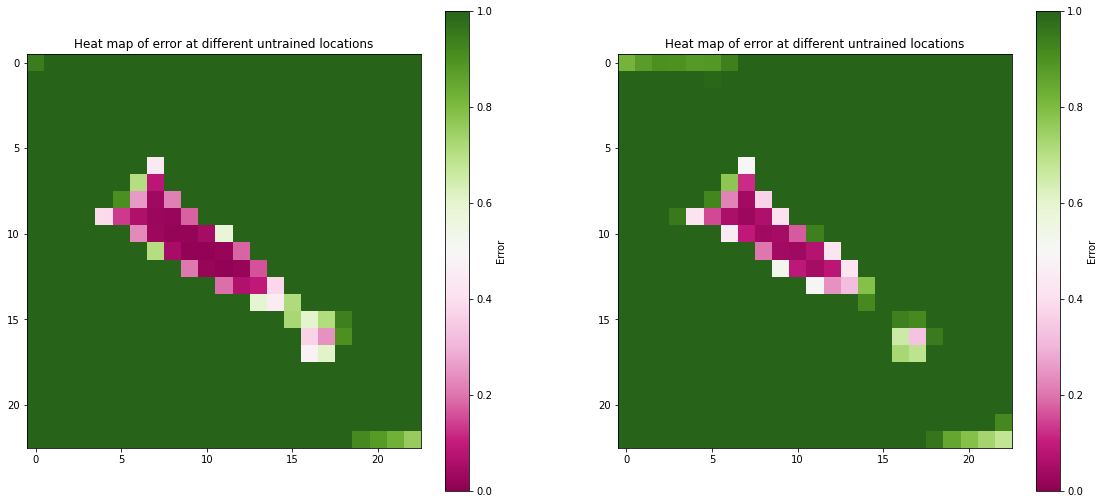

In [36]:
plt.figure(figsize = [30, 30])

plt.subplot(3, 3, 1)
np.random.seed(0)
torch.manual_seed(0)
ghose_net.plot_transfer_score(performance = False, grid = True)


plt.subplot(3, 3, 2)
np.random.seed(0)
torch.manual_seed(0)
test.plot_transfer_score(performance = False, grid = True)
